In [1]:
import seaborn as sns
import pandas as pd
import re
from matplotlib import pyplot as plt
import glob

In [12]:
csv_files = glob.glob("output_runs/*.csv")
data = pd.DataFrame({})

for csv_file in csv_files:
    tmp_df = pd.read_csv(csv_file,delimiter=",")

    data = pd.concat([data,tmp_df],ignore_index=True)
data['IO_perf'] = data['IO_perf'].str.split(' ', n=3, expand=True)[2].astype("float")
data['block_size'] = data['block_size'].str.split(r'\D', n=0, expand=True)[0].astype("float")
data['transfer_size'] = data['transfer_size'].str.split(r'\D', n=0, expand=True)[0].astype("float")
data.loc[data['block_size'] == 256.0,'block_size'] = 0.256
data.loc[data['block_size'] == 512.0,'block_size'] = 0.512

# by changing the blockSize in IOR to adjust file size, 
# file size = blockSize * numTasks * segmentCount
# one segment used
# the transferSize is fixed at 2MB and there is only

data['filesize(GB)'] = data['block_size'] * data['ntasks']
data = data.sort_values(by='partition')

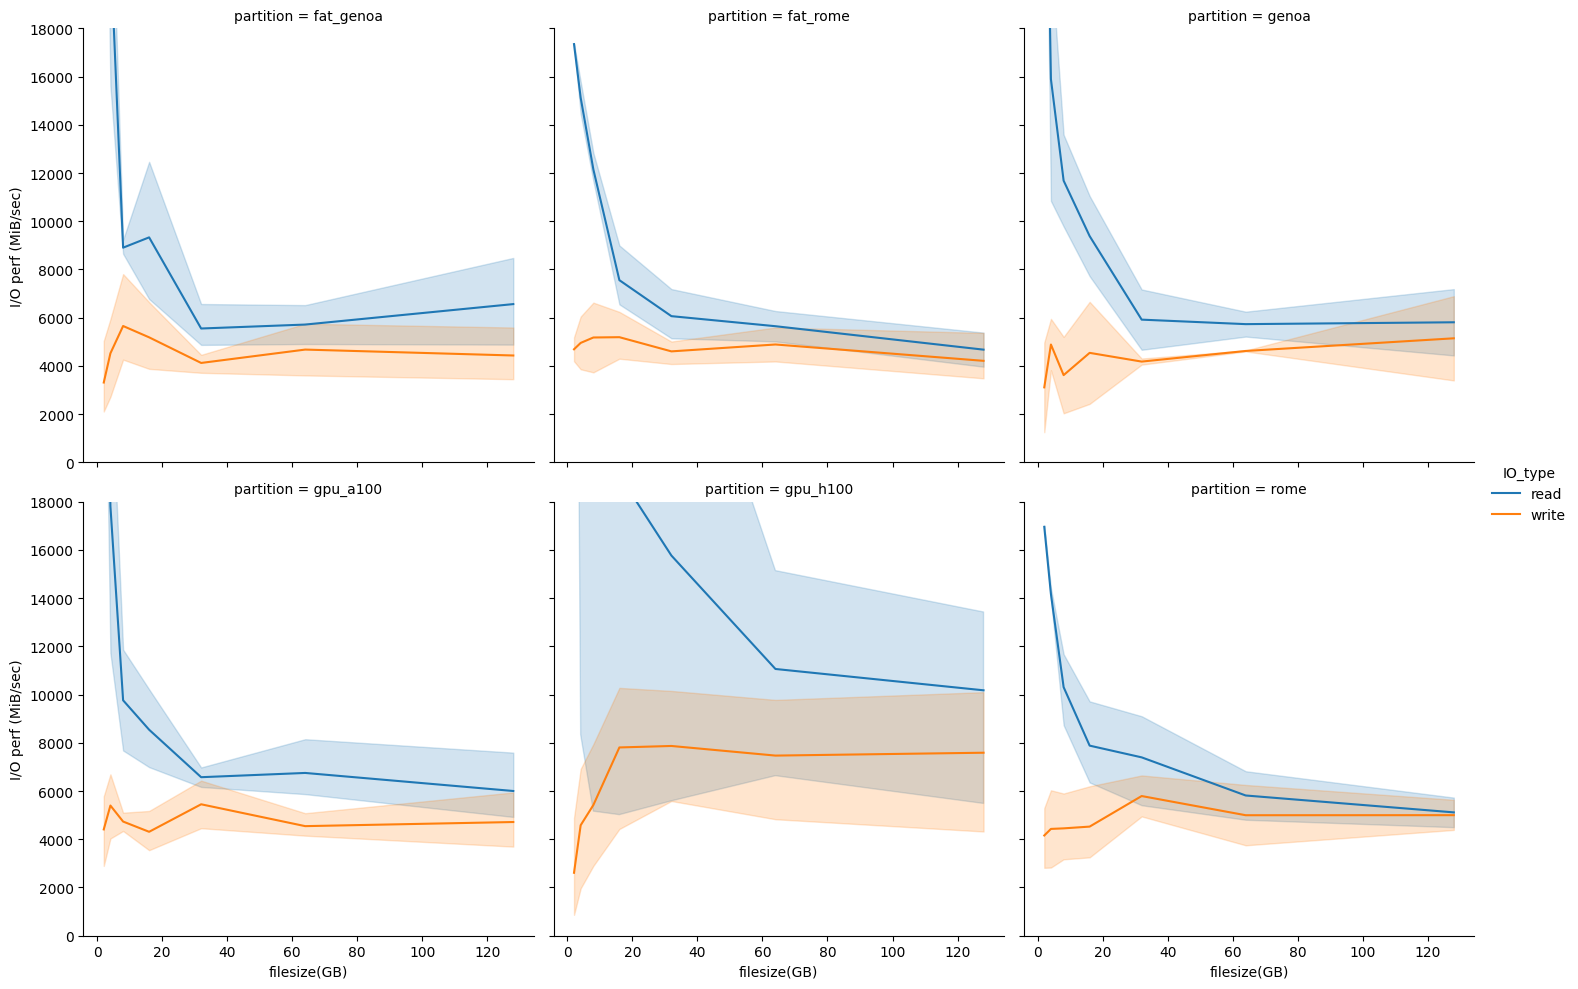

In [14]:
plt.close()
ben = sns.relplot(data=data,x="filesize(GB)", y="IO_perf", col="partition", kind='line', hue="IO_type", col_wrap=3)
ben.set_ylabels("I/O perf (MiB/sec)", clear_inner=False)
plt.ylim(0,18000)
plt.savefig("IO_per_filesize_segment1_transfersize256M_zoom.png",dpi=200)
plt.show()

In [305]:
data = data.sort_values(by='partition')

In [297]:
data

,partition,ntasks,ntasks_per_node,block_size,transfer_size,access_type,toolchain,IO_perf,IO_type,filesize(GB)
0,rome,8,8,0.256,256.0,POSIX,foss_2023,16900.21,read,2.048
1,rome,8,8,0.256,256.0,POSIX,foss_2023,4333.82,write,2.048
2,rome,8,8,0.512,256.0,POSIX,foss_2023,13900.80,read,4.096
3,rome,8,8,0.512,256.0,POSIX,foss_2023,6146.35,write,4.096
4,rome,8,8,1.000,256.0,POSIX,foss_2023,10788.95,read,8.000
...,...,...,...,...,...,...,...,...,...,...
117,gpu_a100,8,8,2.000,256.0,POSIX,foss_2023,5675.28,write,16.000
118,gpu_a100,8,8,4.000,256.0,POSIX,foss_2023,6207.02,read,32.000
119,gpu_a100,8,8,4.000,256.0,POSIX,foss_2023,5663.06,write,32.000
120,gpu_a100,8,8,8.000,256.0,POSIX,foss_2023,5706.19,read,64.000


In [ ]:
partitions= ["genoa", "rome", "fat_genoa", "fat_rome", "gpu_a100", "gpu_h100"]
toolchain="foss_2023"
nodes="1"
procs_per_node="8"
block_sizes = [ "256m", "512m", "1g", "2g", "4g", "8g" ,"16g"]


#

data = pd.DataFrame(columns=["Partition", "toolchain", "nodes", "procs_per_node", "block_size(GB)", "I/O(MiB/sec)", "I/O_Type" ])

for partition in partitions:
    for block_size in block_sizes:

        file = partition + "." + toolchain + ".N" + nodes + "_ppn" + procs_per_node + "." + block_size +".output"

        if "m" in block_size:
            block_size = float(block_size.strip("m"))/1000
        elif "g" in block_size:
            block_size = float(block_size.strip("g"))

        for IO_type in ["Read", "Write"]:

            pattern = re.compile("Max "+IO_type+":\W*[+-]?(?P<number>(\d+\.\d*)|(\.\d+)|(\d+))([eE][+-]?\d+)?")

            tmp_df = pd.DataFrame({    
            "Partition": [partition],
            "toolchain": [toolchain],
            "nodes": [nodes],
            "procs_per_node": [procs_per_node],
            "block_size(GB)": [block_size],
            "I/O_Type": [IO_type],
            })
        
            for i, line in enumerate(open("output_runs/" + file)):
                for match in re.finditer(pattern, line):
                    tmp_df["I/O(MiB/sec)"] = match.groupdict()['number']
    
            data = pd.concat([data,tmp_df],ignore_index=True)
            
data['I/O(MiB/sec)'] = data['I/O(MiB/sec)'].astype('float64') 
data['nodes'] = data['nodes'].astype('float64') 
data['procs_per_node'] = data['procs_per_node'].astype('float64') 

# by changing the blockSize in IOR to adjust file size, 
# file size = blockSize * numTasks * segmentCount
# one segment used
# the transferSize is fixed at 2MB and there is only


data['filesize(GB)'] = data['block_size(GB)'] * data['procs_per_node'] * data['nodes']
